<a href="https://colab.research.google.com/github/MeriSP/Option_Pricing_F_Sub/blob/main/MLP_ShortPaperSpecs_Training_OutputActivationFunction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Importing the necessay libraries**

In [1]:
import os
import sys
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

**2. Uploading the dataset**

In [2]:
# Step 1. Upload file "AlgoSeek_SPy500Jun172022.csv" to Google Colab Document
df = pd.read_csv('/content/sample_data/AlgoSeek_SPy500Jun172022.csv')
df.head(5)

,No,date,TimeBarStart,year,month,day,hour,minute,ticker,call,strike,expiration_date,option_price,underlying_price,moneyness,days_to_ex,std_underlying,treasury_rate
0,1,20220103,10:01:00 AM,2022,1,3,10,1,SPY,C,500,6/17/2022,9.33,475.535,0.95107,118,0.001322,0.22
1,2,20220103,10:05:00 AM,2022,1,3,10,5,SPY,C,500,6/17/2022,9.16,475.195,0.95039,118,0.001181,0.22
2,3,20220103,10:37:00 AM,2022,1,3,10,37,SPY,C,500,6/17/2022,9.37,475.995,0.95199,118,0.001080,0.22
3,4,20220103,11:11:00 AM,2022,1,3,11,11,SPY,C,500,6/17/2022,9.20,475.565,0.95113,118,0.001175,0.22
4,5,20220103,11:18:00 AM,2022,1,3,11,18,SPY,C,500,6/17/2022,9.07,475.240,0.95048,118,0.001065,0.22


**3. Data preprocessing**

In [3]:
# Creating a new column with datatime module.
df['datetime'] = df[['year', 'month', 'day', 'hour', 'minute']].apply(lambda row: datetime.datetime(year=row['year'], month=row['month'], day=row['day'],
                                                                                          hour=row['hour'], minute=row['minute']), axis=1)
# Sorting values in ascending order
df.sort_values('datetime', ascending=True, inplace=True)
df['datetime'].head()

0   2022-01-03 10:01:00
1   2022-01-03 10:05:00
2   2022-01-03 10:37:00
3   2022-01-03 11:11:00
4   2022-01-03 11:18:00
Name: datetime, dtype: datetime64[ns]

In [4]:
# Cleaning the dataframe, selecting feature variables and output for the model.
option_df = df[['datetime', 'moneyness', 'days_to_ex', 'treasury_rate', 'std_underlying', 'option_price']].copy()
option_df.head()

,datetime,moneyness,days_to_ex,treasury_rate,std_underlying,option_price
0,2022-01-03 10:01:00,0.95107,118,0.22,0.001322,9.33
1,2022-01-03 10:05:00,0.95039,118,0.22,0.001181,9.16
2,2022-01-03 10:37:00,0.95199,118,0.22,0.001080,9.37
3,2022-01-03 11:11:00,0.95113,118,0.22,0.001175,9.20
4,2022-01-03 11:18:00,0.95048,118,0.22,0.001065,9.07


**4. Train/Validation Split**

Before starting the training the model we need to create four different arrays separating features variables from the output variables for both training and validation dataset.

In [5]:
# Spliting the data while mantaining the order of the dataset.
split_date = datetime.datetime(year=2022, month=3, day=10, hour=0)
df_train = option_df.loc[df['datetime']<split_date]
df_val = option_df.loc[df['datetime']>=split_date]
print('Shape of train:', df_train.shape)
print('Shape of test:', df_val.shape)

Shape of train: (4008, 6)
Shape of test: (1045, 6)


In [6]:
# Datetime variable is eliminated as it is not a feature variable for the model.
df_train = df_train[['moneyness', 'days_to_ex', 'treasury_rate', 'std_underlying', 'option_price']].copy()
df_train.head()

,moneyness,days_to_ex,treasury_rate,std_underlying,option_price
0,0.95107,118,0.22,0.001322,9.33
1,0.95039,118,0.22,0.001181,9.16
2,0.95199,118,0.22,0.001080,9.37
3,0.95113,118,0.22,0.001175,9.20
4,0.95048,118,0.22,0.001065,9.07


In [7]:
# Datetime variable is eliminated as it is not a feature variable for the model.
df_val = df_val[['moneyness', 'days_to_ex', 'treasury_rate', 'std_underlying', 'option_price']].copy()
df_val.reset_index(inplace = True, drop = True)
df_val.head()

,moneyness,days_to_ex,treasury_rate,std_underlying,option_price
0,0.84551,72,0.38,0.004437,0.65
1,0.84491,72,0.38,0.004218,0.68
2,0.84447,72,0.38,0.004123,0.63
3,0.84587,72,0.38,0.004532,0.67
4,0.84560,72,0.38,0.004523,0.68


In [8]:
def train_X_Y(n_future):
  # Inputs:
  # n_future = Number of days to be predicted in the future based on past days.
  # Output:
  # train_X = 2D array (n_samples, n_features)
  # train_Y = 2D array (n_samples, n_features)

  train_X = []
  train_Y = []

  array_train = df_train.to_numpy()

  for i in range(0, len(array_train ) - n_future +1):
      train_X.append(array_train [i, 0:(array_train.shape[1]-1)])
      train_Y.append(array_train [i + n_future - 1:i + n_future, 4])

  train_X, train_Y = np.array(train_X), np.array(train_Y)
  return train_X, train_Y

In [9]:
n_future = 1 

train_X, train_Y = train_X_Y(n_future)
print('train_X shape == {}'.format(train_X.shape))
print('train_Y shape == {}'.format(train_Y.shape))

train_X shape == (4008, 4)
train_Y shape == (4008, 1)


In [10]:
def valid_X_Y(n_future):
  # Inputs:
  # n_future = Number of days to be predicted in the future based on past days.
  # Output:
  # train_X = 2D array (n_samples, n_features)
  # train_Y = 2D array (n_samples, n_features)

  valid_X = []
  valid_Y = []

  array_valid = df_val.to_numpy()

  for i in range(0, len(array_valid ) - n_future +1):
      valid_X.append(array_valid[i, 0:(array_valid.shape[1]-1)])
      valid_Y.append(array_valid[i + n_future - 1:i + n_future, 4])

  valid_X, valid_Y = np.array(valid_X), np.array(valid_Y)
  return valid_X, valid_Y 

In [11]:
n_future = 1 

valid_X, valid_Y = valid_X_Y(n_future)
print('valid_X shape == {}'.format(valid_X.shape))
print('valid_Y shape == {}'.format(valid_Y.shape))

valid_X shape == (1045, 4)
valid_Y shape == (1045, 1)


**5. Standardizing data**

In [12]:
# Standarization of feature variables is a common requirement for machine learning estimators:
from sklearn import preprocessing

# Preprocessing transforms dataframe into array
scaler_X = preprocessing.StandardScaler().fit(train_X)
scaler_Y = preprocessing.StandardScaler().fit(train_Y)

array_train_scaled_X = scaler_X.transform(train_X)
array_train_scaled_Y = scaler_Y.transform(train_Y)

print('Shape of scaled train X:', array_train_scaled_X.shape)
print('Shape of scaled train Y:', array_train_scaled_Y.shape)

Shape of scaled train X: (4008, 4)
Shape of scaled train Y: (4008, 1)


In [13]:
# Preprocessing transforms dataframe into array
array_val_scaled_X = scaler_X.transform(valid_X)
array_val_scaled_Y = scaler_Y.transform(valid_Y)
print('Shape of scaled test X:', array_val_scaled_X.shape)
print('Shape of scaled test Y:', array_val_scaled_Y.shape)

Shape of scaled test X: (1045, 4)
Shape of scaled test Y: (1045, 1)


**6. Defining the model**

In [14]:
from keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam, Nadam 
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [15]:
# Defining the shape of the input layer as (None, 4),
# where "None" indicates the number of instances
# data type is float32
input_shape = array_train_scaled_X[0,:].shape
model_input = Input(shape=input_shape, dtype='float32')

In [16]:
# OUTPUT ACTIVATION LAYER = Softplus

def mlp_model_specs(model_input):
  #Dense layers are defined with LeakyReLU activation function
  dense1 = Dense(120, activation='LeakyReLU')(model_input)
  dense2 = Dense(120, activation='LeakyReLU')(dense1)
  dense3 = Dense(120, activation='LeakyReLU')(dense2)
  dense4 = Dense(120, activation='LeakyReLU')(dense3)
  dropout_layer = Dropout(0.2)(dense4)
  #Finally the output layer gives prediction for the next trading option price
  output_layer = Dense(1, activation='softplus')(dropout_layer)
  model = Model(model_input, output_layer, name='mlp_model')
  return model

In [17]:
mlp_model_1 = mlp_model_specs(model_input)

In [18]:
# Hyperparameters
num_epochs = 20
batch_size=16

In [19]:
def compile_and_train(model, num_epochs, batch_size): 
  model.compile(loss='mse', optimizer='adam')
  model.summary()
  save_weights_at = os.path.join('keras_mlp_models', 'Option_Prices_MLP_weights.{epoch:02d}-{val_loss:.4f}.hdf5')
  save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0, save_weights_only=False,
                                                 save_best_only=True, mode='min', period=1)
  history = model.fit(x=array_train_scaled_X, y=array_train_scaled_Y, batch_size=batch_size, 
                     epochs=num_epochs, verbose=1, callbacks=[save_best], 
                     validation_data=(array_val_scaled_X, array_val_scaled_Y), shuffle=True)
  return history

In [20]:
mlp_model_history = compile_and_train(mlp_model_1, num_epochs, batch_size)

Model: "mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 120)               600       
                                                                 
 dense_1 (Dense)             (None, 120)               14520     
                                                                 
 dense_2 (Dense)             (None, 120)               14520     
                                                                 
 dense_3 (Dense)             (None, 120)               14520     
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 12

In [22]:
# OUTPUT ACTIVATION LAYER = relu

def mlp_model_specs_2(model_input):
  #Dense layers are defined with LeakyReLU activation function
  dense1 = Dense(120, activation='LeakyReLU')(model_input)
  dense2 = Dense(120, activation='LeakyReLU')(dense1)
  dense3 = Dense(120, activation='LeakyReLU')(dense2)
  dense4 = Dense(120, activation='LeakyReLU')(dense3)
  dropout_layer = Dropout(0.2)(dense4)
  #Finally the output layer gives prediction for the next trading option price
  output_layer = Dense(1, activation='relu')(dropout_layer)
  model = Model(model_input, output_layer, name='mlp_model')
  return model

In [25]:
mlp_model_2 = mlp_model_specs_2(model_input)

In [27]:
mlp_model_history_2 = compile_and_train(mlp_model_2, num_epochs, batch_size)

Model: "mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_10 (Dense)            (None, 120)               600       
                                                                 
 dense_11 (Dense)            (None, 120)               14520     
                                                                 
 dense_12 (Dense)            (None, 120)               14520     
                                                                 
 dense_13 (Dense)            (None, 120)               14520     
                                                                 
 dropout_2 (Dropout)         (None, 120)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 12

In [34]:
# OUTPUT ACTIVATION LAYER = linear

def mlp_model_specs_3(model_input):
  #Dense layers are defined with LeakyReLU activation function
  dense1 = Dense(120, activation='LeakyReLU')(model_input)
  dense2 = Dense(120, activation='LeakyReLU')(dense1)
  dense3 = Dense(120, activation='LeakyReLU')(dense2)
  dense4 = Dense(120, activation='LeakyReLU')(dense3)
  dropout_layer = Dropout(0.2)(dense4)
  #Finally the output layer gives prediction for the next trading option price
  output_layer = Dense(1, activation='linear')(dropout_layer)
  model = Model(model_input, output_layer, name='mlp_model')
  return model

In [29]:
mlp_model_3 = mlp_model_specs_3(model_input)

In [30]:
mlp_model_history_3 = compile_and_train(mlp_model_3, num_epochs, batch_size)

Model: "mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_15 (Dense)            (None, 120)               600       
                                                                 
 dense_16 (Dense)            (None, 120)               14520     
                                                                 
 dense_17 (Dense)            (None, 120)               14520     
                                                                 
 dense_18 (Dense)            (None, 120)               14520     
                                                                 
 dropout_3 (Dropout)         (None, 120)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 12

In [31]:
# Chosing the best epoch for the calculation of predictions.
best_model_mlp = load_model(os.path.join('keras_mlp_models', 'Option_Prices_MLP_weights.01-0.0476.hdf5'))
preds_mlp = best_model_mlp(array_val_scaled_X)

# Option_Prices_MLP_weights.01-0.0476.hdf5, 17/05/2022

In [32]:
# Reversing the standard scalar transformation
preds_mlp_Y = scaler_Y.inverse_transform(preds_mlp)

In [33]:
# Checking the results obtained
preds_mlp_df = pd.DataFrame(preds_mlp_Y)
preds_mlp_df[0].describe()

count    1045.000000
mean        1.211049
std         0.482852
min         0.169282
25%         0.850318
50%         1.225625
75%         1.606342
max         2.248483
Name: 0, dtype: float64

**7. Results**

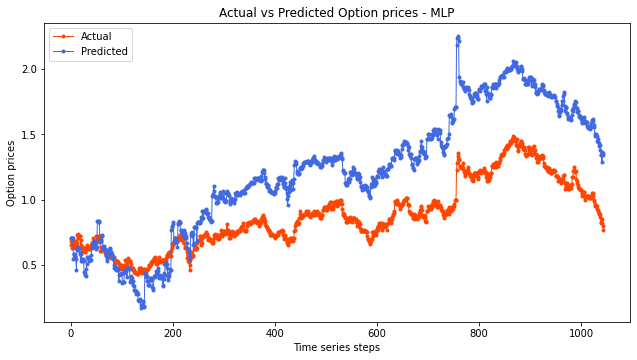

In [35]:
# Plotting actual vs predicted values
plt.figure(figsize=(10.5, 5.5))
plt.plot(df_val['option_price'], linestyle='-', marker='.', linewidth=1, color='orangered')
plt.plot(preds_mlp_df, linestyle='-', marker='.', linewidth=1, color='royalblue')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted Option prices - MLP')
plt.ylabel('Option prices')
plt.xlabel('Time series steps')
plot_path = 'sample_data'
plot_file = 'mlp.png'
plt.savefig(os.path.join(plot_path, plot_file), format='png', dpi=300)

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from math import sqrt

In [37]:
# Creating a dataframe for validation data
actual_option_df = df_val[['option_price']].copy()
actual_option_df.shape

(1045, 1)

In [38]:
def compute_metrics():
  rmse = sqrt(mean_squared_error(actual_option_df, preds_mlp_df))
  mae = mean_absolute_error(actual_option_df, preds_mlp_df)
  mape = mean_absolute_percentage_error(actual_option_df, preds_mlp_df)
  r_squared = r2_score(actual_option_df, preds_mlp_df)
  return rmse, mae, mape, r_squared

In [39]:
rmse, mae, mape, r_squared = compute_metrics()

print('RMSE for the validation set:', round(rmse, 4))
print('MAE for the validation set:', round(mae, 4))
print('MAPE for the validation set:', round(mape, 4))
print('R Squared for the validation set:', round(r_squared, 4))

RMSE for the validation set: 0.4134
MAE for the validation set: 0.3659
MAPE for the validation set: 0.3932
R Squared for the validation set: -1.602
